# XGBoost - Anwendung (Lead Time 1 Stunde)

### Teilung in Trainings- und Testset
In diesem Block werden alle Zeitreihen zeitbasiert in Trainings- und Testsets aufgeteilt. Das Trainingsset umfasst alle Einträge von 2010 bis einschließlich 2021 (Zeitstempel vor dem 0.01.2022). Die späteren Einträge werden dem Testset zugeordnet. Anschließend werden die Abflusszeitreihen ("Abfluss in m^3/s") visualisiert, wobei das Trainingsset in blau und das Testset in orange dargestellt ist. Die Visualisierung dient der Übersichtlichkeit. In der Arbeit wurde diese Trennung am Beispiel von Gießen Argen veranschaulicht.

Created train (105192 rows) and test data (26304 rows) for Gießen Argen-Hydrologische Landespegel_interpolated_merged_nan.csv.
Created train (105192 rows) and test data (26304 rows) for Blaubeuren Blau-Hydrologische Landespegel_interpolated_merged_nan.csv.
Created train (105192 rows) and test data (26304 rows) for Bolheim Brenz-Hydrologische Landespegel_interpolated_merged_nan.csv.
Created train (105192 rows) and test data (26304 rows) for Beuron Donau-Hydrologische Landespegel_interpolated_merged_nan.csv.
Created train (105192 rows) and test data (26304 rows) for Hundersingen Donau-Hydrologische Landespegel_interpolated_merged_nan.csv.
Created train (105192 rows) and test data (26304 rows) for Wannweil Echaz-Hydrologische Landespegel_interpolated_merged_nan.csv.
Created train (105192 rows) and test data (26304 rows) for Eutingen Enz-Hydrologische Landespegel_interpolated_merged_nan.csv.
Created train (105192 rows) and test data (26304 rows) for Elpershofen Jagst-Hydrologische Landespe

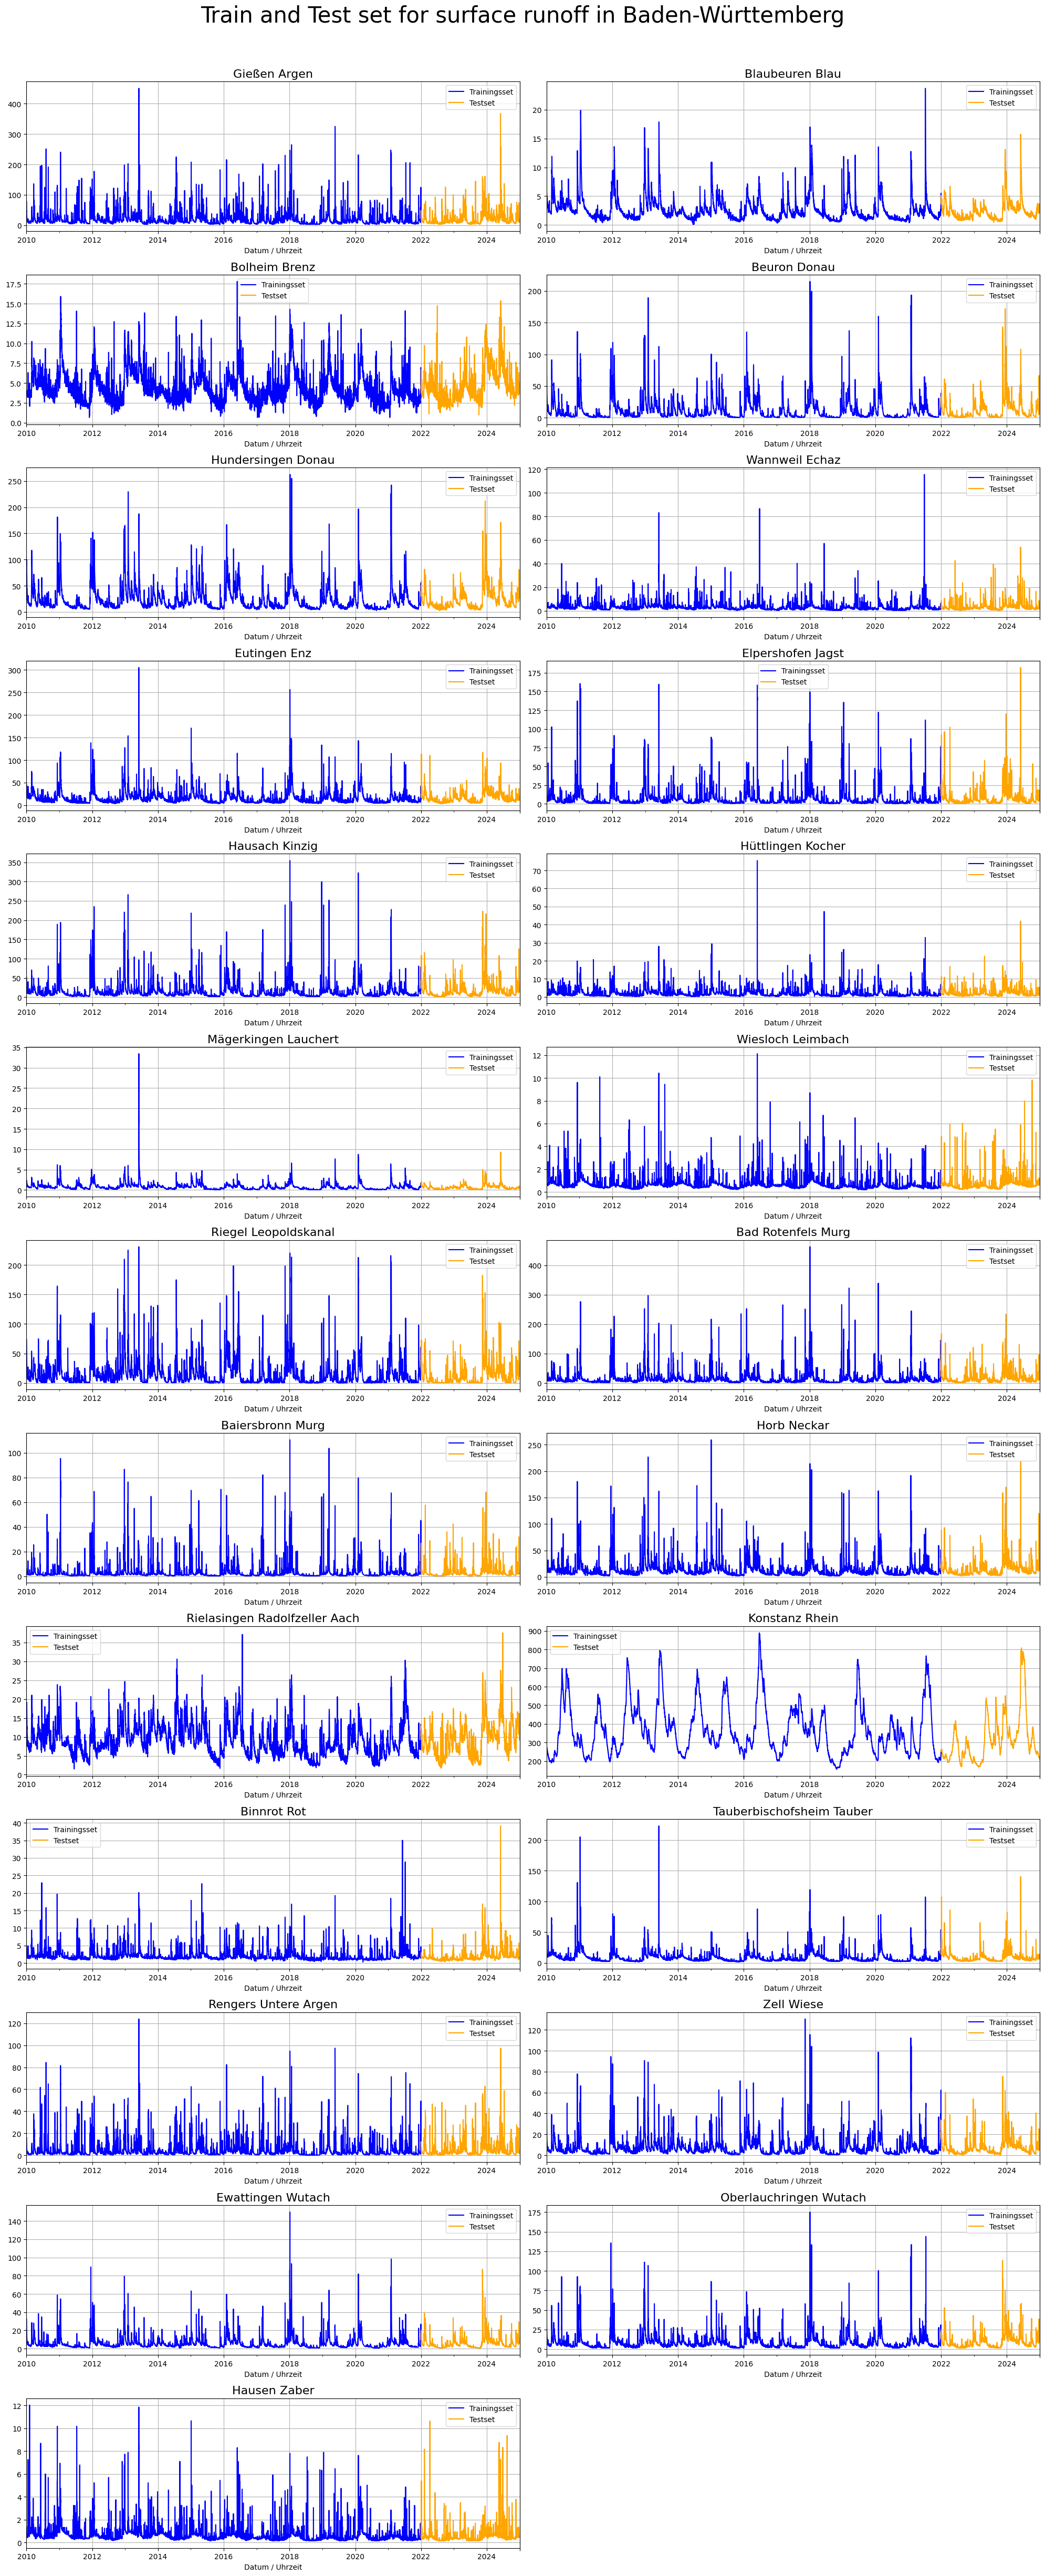

In [2]:
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import glob

# split the respective data sets in train and testset and store them in train_and_test_nan and plot them so that we can see what is the train and what is the test set
all_merged_files_nan=glob.glob("Datensätze/UDO-LUBW/Endgültige Auswahl Landespegel Hydrologie/Gewässer/*/*/*_merged_nan.csv")

def make_train_test():
    train_and_test_nan = []
    for a in all_merged_files_nan:
        p = Path(a)
        
        # read the respective file as a data frame.
        df_water_station = pd.read_csv(p, sep=",", index_col="Datum / Uhrzeit", parse_dates=["Datum / Uhrzeit"], encoding="utf-8")

        water = df_water_station["Gewässer"].iloc[0]
        station = df_water_station["Stationsname"].iloc[0]

        train_data = df_water_station[df_water_station.index < "2022-01-01"]
        test_data = df_water_station[df_water_station.index >= "2022-01-01"]

        train_and_test_nan.append({
            "Gewässer": water, "Stationsname": station, "Trainingsset": train_data, "Testset": test_data
        })

        print(f"Created train ({len(train_data)} rows) and test data ({len(test_data)} rows) for {p.name}.")

    return train_and_test_nan

def plot_every_train_test(train_and_test):
    plotted = []
    fig, axes = plt.subplots(13,2, figsize=(20, 50))
    axes = axes.ravel()
    for i,p in enumerate(train_and_test):

        station = p["Stationsname"]
        df_train = p["Trainingsset"]
        df_test = p["Testset"]

        df_train["Abfluss in m^3/s"].plot(ax=axes[i], label="Trainingsset", color="blue")
        df_test["Abfluss in m^3/s"].plot(ax=axes[i], label="Testset", color="orange")
        axes[i].set_title(f"{station}", fontsize=16)
        axes[i].grid(True)
        axes[i].legend()
    for j in range(len(train_and_test), 26):
        axes[j].set_visible(False)

    fig.suptitle("Train and Test set for surface runoff in Baden-Württemberg", fontsize=30)
    fig.tight_layout(rect=[0, 0, 1, 0.97])
    plt.show()
    

train_and_test = make_train_test()
plotted = plot_every_train_test(train_and_test)

### Feature Creation
In diesem Block wird die Attributmatrix für die Modellierung erstellt. Dazu werden Zeitmerkmale aus dem Zeitindex abgeleitet ("Stunde", "Tage in einer Woche", "Monat", "Viertel Jahr", "Jahr", "Tage im Jahr"). Zusätzlich werden zyklische Zeitinformationen über Sinus und Cosinus ("Sinus Tag", "Cosinus Tag", "Sinus Jahr", "Cosinus Jahr") abgebildet, damit die Modelle periodische Muster lernen können. 
Darüber hinaus werden Lag-Features erzeugt (1, 3, 6, 12, 24, 48, 72, 168, 720, 8760 Stunden), um Informationen aus der Vergangenheit in die Vorhersage einzubeziehen (Von Bedeutung wegen Autokorrelation in Abflusszeitreihen). Diese gehen als Spalten "Abfluss in m^3/s_lag{lag}" in die Attributmatrix ein. 
Da Niederschlag häufig zeitverzögert auf den Abfluss wirkt, werden auch die zugeordneten Niederschlagszeitreihen um 0, 1, 3, 6, 12, 24, 36, 48 Stunden verschoben. Diese Merkmale werden als "{column}_lag{lag}" ergänzt. Die konstanten Spalten "Stationsname", "Gewässer", "Interpoliert" werden abschließend entfernt.

In [17]:
import pandas as pd
import numpy as np
from pathlib import Path
import glob

# Create new time series for all 25 stations which is enriched by feauters an which based on datetime index.
def feature_creation_nan():
    all_merged_files_nan=glob.glob("Datensätze/UDO-LUBW/Endgültige Auswahl Landespegel Hydrologie/Gewässer/*/*/*_merged_nan.csv")

    
    all_water_stations = []
    for a in all_merged_files_nan:
        p = Path(a)
        
        # read the respective file as a data frame.
        df_water_station = pd.read_csv(p, sep=",", index_col="Datum / Uhrzeit", parse_dates=["Datum / Uhrzeit"], encoding="utf-8")

        df_water_station = df_water_station.sort_index()
        
        # save "Stationsname" and "Gewässer" separately. I will drop them later on in the features.
        station_and_water = df_water_station[["Stationsname", "Gewässer"]]
        
        # defining time features by creating them from the datetime index
        df_water_station["Stunde"] = df_water_station.index.hour
        df_water_station["Tage in einer Woche"] = df_water_station.index.dayofweek
        df_water_station["Monat"] = df_water_station.index.month
        df_water_station["Viertel Jahr"] = df_water_station.index.quarter
        df_water_station["Jahr"] = df_water_station.index.year
        df_water_station["Tage im Jahr"] = df_water_station.index.dayofyear


        # defining cyclic features by calculating daily and yearly cycles (as sinus and cosinus).
        df_water_station["Sinus Tag"] = np.sin(2 * np.pi * df_water_station["Stunde"] / 24)
        df_water_station["Cosinus Tag"] = np.cos(2 * np.pi * df_water_station["Stunde"] / 24)
        df_water_station["Sinus Jahr"] = np.sin(2 * np.pi * df_water_station["Tage im Jahr"] / 365)
        df_water_station["Cosinus Jahr"] = np.cos(2 * np.pi * df_water_station["Tage im Jahr"] / 365)

        # defining lag features by shifting the original "Abfluss in m^3/s" to enable connecting with past surface runoff.
        # store them in a separate data frame to avoid warnings
        lags_water = {}
        for lag in [1, 3, 6, 12, 24, 48, 72, 168, 720, 8760]:
            lags_water[f"Abfluss in m^3/s_lag{lag}"] = df_water_station["Abfluss in m^3/s"].shift(lag)
        df_lags_water = pd.DataFrame(lags_water, index=df_water_station.index)

        # defining lag features for exogenous variables by shifting the original precipitation columns to capture their delayed impact on the surface runoff. 
        # store them in a separate data frame to avoid warnings
        lags_exogene = {}
        for column in df_water_station.filter(regex=r"^Niederschlag").columns:
            for lag in [0, 1, 3, 6, 12, 24, 36, 48]:
                lags_exogene[f"{column}_lag{lag}"] = df_water_station[column].shift(lag)
        df_lags_exogene = pd.DataFrame(lags_exogene, index=df_water_station.index)

        # Concatenate the data frames to one
        df_water_station = pd.concat([df_water_station, df_lags_water, df_lags_exogene], axis=1)
        

        # remove static columns or columns that are not used as features for the model
        df_water_station = df_water_station.drop(columns=["Stationsname", "Gewässer", "Interpoliert"])
                
        all_water_stations.append({
            "Stationsname": station_and_water["Stationsname"].iloc[0],
            "Gewässer": station_and_water["Gewässer"].iloc[0],
            "df": df_water_station
        })
        print(f"Create features for {p.name}.")

    return all_water_stations

feature_creation_nan()




Create features for Gießen Argen-Hydrologische Landespegel_interpolated_merged_nan.csv.
Create features for Blaubeuren Blau-Hydrologische Landespegel_interpolated_merged_nan.csv.
Create features for Bolheim Brenz-Hydrologische Landespegel_interpolated_merged_nan.csv.
Create features for Beuron Donau-Hydrologische Landespegel_interpolated_merged_nan.csv.
Create features for Hundersingen Donau-Hydrologische Landespegel_interpolated_merged_nan.csv.
Create features for Wannweil Echaz-Hydrologische Landespegel_interpolated_merged_nan.csv.
Create features for Eutingen Enz-Hydrologische Landespegel_interpolated_merged_nan.csv.
Create features for Elpershofen Jagst-Hydrologische Landespegel_interpolated_merged_nan.csv.
Create features for Hausach Kinzig-Hydrologische Landespegel_interpolated_merged_nan.csv.
Create features for Hüttlingen Kocher-Hydrologische Landespegel_interpolated_merged_nan.csv.
Create features for Mägerkingen Lauchert-Hydrologische Landespegel_interpolated_merged_nan.csv.


[{'Stationsname': 'Gießen Argen',
  'Gewässer': 'Argen',
  'df':                      Abfluss in m^3/s  Niederschlag 6258 in mm  \
  Datum / Uhrzeit                                                  
  2010-01-01 00:00:00            78.308                      0.0   
  2010-01-01 01:00:00            75.247                      0.0   
  2010-01-01 02:00:00            73.206                      0.0   
  2010-01-01 03:00:00            69.861                      0.0   
  2010-01-01 04:00:00            67.697                      0.0   
  ...                               ...                      ...   
  2024-12-31 19:00:00            11.832                      0.0   
  2024-12-31 20:00:00            11.037                      0.0   
  2024-12-31 21:00:00            10.951                      0.0   
  2024-12-31 22:00:00            10.797                      0.0   
  2024-12-31 23:00:00            10.783                      0.0   
  
                       Niederschlag 4094 in mm  Ni

## Hyperparameter Tuning mit Cross Validation

### Teilung in Trainings- und Testset
In diesem Block werden alle Zeitreihen zeitbasiert in Trainings- und Testsets aufgeteilt. Das Trainingsset umfasst alle Einträge von 2010 bis einschließlich 2021 (Zeitstempel vor dem 0.01.2022). Die späteren Einträge werden dem Testset zugeordnet. 

In [18]:
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import glob

# split the stations time series in train and test sets
def train_and_test_nan():
    # create the features for every station
    water_stations = feature_creation_nan()
    train_test_nan = []

    # defining the timestamp separating the train and test data
    split_train_test = pd.Timestamp("2022-01-01")
    for a in water_stations:
        
        # defining important information to identify the correct train and test set for the respective station
        water = a["Gewässer"]
        station = a["Stationsname"]
        df_water_station = a["df"]

        # splitting the respective time series into train and test data (ratio: 80% train set, 20% test set)
        # (train set until 2021-12-31, test set from 2022-01-01)
        train_data = df_water_station[df_water_station.index < split_train_test]
        test_data = df_water_station[df_water_station.index >= split_train_test]

        # store the respective split with the meta data in train_test_nan
        train_test_nan.append({
            "Gewässer": water, "Stationsname": station, "Trainingsset": train_data, "Testset": test_data
        })

        print(f"Created train ({len(train_data)} rows) and test data ({len(test_data)} rows) for {station}.")

    return train_test_nan



train_and_test_nan()



Create features for Gießen Argen-Hydrologische Landespegel_interpolated_merged_nan.csv.
Create features for Blaubeuren Blau-Hydrologische Landespegel_interpolated_merged_nan.csv.
Create features for Bolheim Brenz-Hydrologische Landespegel_interpolated_merged_nan.csv.
Create features for Beuron Donau-Hydrologische Landespegel_interpolated_merged_nan.csv.
Create features for Hundersingen Donau-Hydrologische Landespegel_interpolated_merged_nan.csv.
Create features for Wannweil Echaz-Hydrologische Landespegel_interpolated_merged_nan.csv.
Create features for Eutingen Enz-Hydrologische Landespegel_interpolated_merged_nan.csv.
Create features for Elpershofen Jagst-Hydrologische Landespegel_interpolated_merged_nan.csv.
Create features for Hausach Kinzig-Hydrologische Landespegel_interpolated_merged_nan.csv.
Create features for Hüttlingen Kocher-Hydrologische Landespegel_interpolated_merged_nan.csv.
Create features for Mägerkingen Lauchert-Hydrologische Landespegel_interpolated_merged_nan.csv.


[{'Gewässer': 'Argen',
  'Stationsname': 'Gießen Argen',
  'Trainingsset':                      Abfluss in m^3/s  Niederschlag 6258 in mm  \
  Datum / Uhrzeit                                                  
  2010-01-01 00:00:00            78.308                      0.0   
  2010-01-01 01:00:00            75.247                      0.0   
  2010-01-01 02:00:00            73.206                      0.0   
  2010-01-01 03:00:00            69.861                      0.0   
  2010-01-01 04:00:00            67.697                      0.0   
  ...                               ...                      ...   
  2021-12-31 19:00:00            49.543                      0.0   
  2021-12-31 20:00:00            48.711                      0.0   
  2021-12-31 21:00:00            47.784                      0.0   
  2021-12-31 22:00:00            47.063                      0.0   
  2021-12-31 23:00:00            46.322                      0.0   
  
                       Niederschlag 4094

### Hyperparameter-Optimierung
In diesem Abschnitt werden die Hyperparameter des XGBoost für die spätere Vorhersage der Testsets aller 25 Zeitreihen optimiert. Für das Tuning werden drei repräsentative Zeitreihen verwendet, die anhand des Variationskoeffizienten (hoch, mittel, niedrig) ausgewählt wurden ("Elpershofen Jagst", "Mägerkingen Lauchert", "Konstanz Rhein"). 
Es wird eine Grid-Search mit TimeSeriesSplit-Cross-Validation durchgeführt. Pro Station werden 7 Folds verwendet. Das Validierungsset umfasst dabei jeweils 720 Stunden. Zur Vermeidung von Leakage wird eine Lücke von einer Stunde ("gap=1") zwischen trainingsset und Validierungsset gesetzt. Die Zielgröße ist dabei eine 1-Stunden-Vorhersage (y=Abfluss(t+1)).
Bewertet werden hier RMSE, MAE und NSE. Der Output zeigt dabei die Hyperparameterkombination mit dem niedrigsten mittleren RMSE und MAE sowie der höchsten mittleren NSE über alle Folds und repräsentativen Stationen.
Als primäres Auswahlkriterium wurde die NSE verwendet. Darüber hinaus wurde die Diferenz zwischen Trainings-NSE und Validierungs-NSE ("nse gap") betrachtet, um ggfs. ein mögliches Overfitting zu erkennen und diesem später entgegenwirken zu können. Randbemerkung: Mit horizon ist die Lead Time der Vorhersage gemeint, also t --> Q(t+1)

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
from itertools import product
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error


def hyper_parameter_tuning_cross_validation():
    train_test = train_and_test_nan()

    # define possible parameters
    params = {
                "n_estimators": [100, 200, 300, 500],
                "max_depth": [3, 6, 8],
                "learning_rate": [0.05, 0.1],
                "subsample": np.linspace(0.5, 1.0, 3),
                "colsample_bytree": np.linspace(0.5, 1.0, 3),
            }
    keys = params.keys()
    values = params.values()
    params_columns = list(keys)

    # create all hyperparameter combinations a list of dictionaries. Each of them containing one hyper parameter combination.
    dict_all_combination = []
    all_combination = list(product(*values))
    for c in all_combination:
        dict_combination = dict(zip(keys, c))
        dict_all_combination.append(dict_combination)
            
    pred = []
    scores = []

    # try every hyperparameter combination of the grid.
    for d in dict_all_combination:
        selected_stations = ["Elpershofen Jagst", "Mägerkingen Lauchert", "Konstanz Rhein"]
        selected_train_test = [t for t in train_test if t["Stationsname"] in selected_stations]

        
        for t in selected_train_test:
            train_water = t["Trainingsset"].copy()
            train_water = train_water.sort_index()
            # define forecast horizon to forecast one hour in the future.
            train_water["y"] = train_water["Abfluss in m^3/s"].shift(-1)
    
            # the last row of y is NaN due to the shift by one hour. Because it is the target and because it doesn't make sense to predict something which doesn't exist, we need to drop it.
            train_water = train_water.dropna(subset=["y"])
    
            # define x and y for cross validation before the split because this is more efficient. Drop "y" for x, because "y" is the part to forecast. We keep "Abfluss in m^3/s" as current value and the last knon runoff which is important for the prediction. 
            x = train_water.drop(columns=["y"])
            y = train_water["y"]
            
            station = t["Stationsname"]
    
            # define Time Series Spliit for the Cross validation. We evaluate the model on 720 hour validation windows using one hour forecasts. 
            # To avoid leakage between train and validation I use a gap of one hour.
            tss = TimeSeriesSplit(n_splits=7, test_size=720, gap=1)
            fold = 0

            # split the train set into seven folds for the cross validation and use XGBoostRegressor with the respective hyperparameter combination.
            for train_idx, validation_idx in tss.split(x):
                fold += 1
                x_train = x.iloc[train_idx]
                x_validation = x.iloc[validation_idx]
                y_train = y.iloc[train_idx]
                y_validation = y.iloc[validation_idx]
                
                model = xgb.XGBRegressor(
                    **d,
                    base_score=0.5, 
                    tree_method="hist", 
                    n_jobs = -1, 
                    random_state=42,
                    eval_metric="rmse"
                )
                    
                model.fit(
                    x_train, y_train,
                    eval_set=[(x_validation, y_validation)],
                    verbose=100
                )
                
                
                # this is needed to predict the validation set    
                y_pred_validation = model.predict(x_validation)
                pred.append({
                    **d,
                    "Stationsname": station,
                    "Fold": fold, 
                    "Vorhersage": y_pred_validation
                 })

                # this is needed to check for overfitting: If the training metrics are much better than the validation metrics, the model might be overfitting
                y_pred_train = model.predict(x_train)

                # calculate the evaluation metrics for the validation set forecast in the cross validation
                rmse_validation = np.sqrt(mean_squared_error(y_validation, y_pred_validation))
                mae_validation = mean_absolute_error(y_validation, y_pred_validation)
                nse_validation = 1 - np.sum((y_validation - y_pred_validation)**2) / np.sum((y_validation - np.mean(y_validation))**2)

                # calculate the evaluation metrics for the training set forecast in the cross validation to compare them with the claculated metrics in the validation set forecast.
                rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
                mae_train = mean_absolute_error(y_train, y_pred_train)
                nse_train = 1 - np.sum((y_train - y_pred_train)**2) / np.sum((y_train - np.mean(y_train))**2)

                # store information about the respective hyperparameter, station and fold with the corresponding metrics
                scores.append({
                    **d,
                    "Stationsname": station,
                    "Fold": fold,
                    "rmse validation": rmse_validation,
                    "mae validation": mae_validation,
                    "nse validation": nse_validation,
                    "rmse train": rmse_train,
                    "mae train": mae_train,
                    "nse train": nse_train,
                })
                print(f"Calculated CV RMSE for {t['Stationsname']} with RMSE: {rmse_validation}.")
                print(f"Calculated CV MAE for {t['Stationsname']} with MAE: {mae_validation}.")
                print(f"Calculated CV NSE for {t['Stationsname']} with NSE: {nse_validation}.")

    # calculate the mean evaluation metrics over the folds with the same station and hyperparameter combination
    scores_df = pd.DataFrame(scores)
    mean_per_station = scores_df.groupby(["Stationsname"] + params_columns)[["rmse validation", "mae validation", "nse validation", "rmse train", "mae train", "nse train"]].mean()
    mean_per_station = mean_per_station.reset_index()
    mean_per_station = mean_per_station.rename(columns={"rmse validation": "mean_rmse_validation", "mae validation": "mean_mae_validation", "nse validation": "mean_nse_validation", "rmse train": "mean_rmse_train", "mae train": "mean_mae_train", "nse train": "mean_nse_train"})

    # calculate the mean evaluation metrics of all stations with the same hyperparameter configurations to find the best hyper parameter combination for all stations. We also want to calculate the evaluation metrics in the train set to identify if the model realy learns to regularize ore just to memorize if the metrics in the train set are much betterthan the metrics in the validation set.
    mean_per_hyper_parameter = mean_per_station.groupby(params_columns)[["mean_rmse_validation", "mean_mae_validation", "mean_nse_validation", "mean_rmse_train", "mean_mae_train", "mean_nse_train"]].mean()
    mean_per_hyper_parameter = mean_per_hyper_parameter.reset_index()
    mean_per_hyper_parameter["nse gap"] = mean_per_hyper_parameter["mean_nse_train"] - mean_per_hyper_parameter["mean_nse_validation"]

    # sort the evaluation metrics to show the best hyperparameter for the best metric
    sorted_rmse = mean_per_hyper_parameter.sort_values("mean_rmse_validation")
    sorted_mae = mean_per_hyper_parameter.sort_values("mean_mae_validation")
    sorted_nse = mean_per_hyper_parameter.sort_values("mean_nse_validation", ascending=False)

    # define the best hyperparameters per evaluation metric
    best_hp_rmse = sorted_rmse[params_columns].iloc[0]
    best_hp_mae = sorted_mae[params_columns].iloc[0]
    best_hp_nse = sorted_nse[params_columns].iloc[0]

    print(f"Best Hyperparameter combination with lowest mean rmse for all stations are {best_hp_rmse} with mean rmse {sorted_rmse['mean_rmse_validation'].iloc[0]} with nse gap between train and validation of: {sorted_rmse['nse gap'].iloc[0]}.")
    print(f"Best Hyperparameter combination with lowest mean mae for all stations are {best_hp_mae} with mean mae {sorted_mae['mean_mae_validation'].iloc[0]} with nse gap between train and validation of: {sorted_mae['nse gap'].iloc[0]}.")
    print(f"Best Hyperparameter combination with lowest mean nse for all stations are {best_hp_nse} with mean nse {sorted_nse['mean_nse_validation'].iloc[0]} with nse gap between train and validation of: {sorted_nse['nse gap'].iloc[0]}.")

    return best_hp_rmse, best_hp_mae, best_hp_nse

hyper_parameter_tuning_cross_validation()
        
            

Create features for Gießen Argen-Hydrologische Landespegel_interpolated_merged_nan.csv.
Create features for Blaubeuren Blau-Hydrologische Landespegel_interpolated_merged_nan.csv.
Create features for Bolheim Brenz-Hydrologische Landespegel_interpolated_merged_nan.csv.
Create features for Beuron Donau-Hydrologische Landespegel_interpolated_merged_nan.csv.
Create features for Hundersingen Donau-Hydrologische Landespegel_interpolated_merged_nan.csv.
Create features for Wannweil Echaz-Hydrologische Landespegel_interpolated_merged_nan.csv.
Create features for Eutingen Enz-Hydrologische Landespegel_interpolated_merged_nan.csv.
Create features for Elpershofen Jagst-Hydrologische Landespegel_interpolated_merged_nan.csv.
Create features for Hausach Kinzig-Hydrologische Landespegel_interpolated_merged_nan.csv.
Create features for Hüttlingen Kocher-Hydrologische Landespegel_interpolated_merged_nan.csv.
Create features for Mägerkingen Lauchert-Hydrologische Landespegel_interpolated_merged_nan.csv.


(n_estimators        200.00
 max_depth             6.00
 learning_rate         0.05
 subsample             0.75
 colsample_bytree      1.00
 Name: 77, dtype: float64,
 n_estimators        100.00
 max_depth             8.00
 learning_rate         0.10
 subsample             0.75
 colsample_bytree      1.00
 Name: 50, dtype: float64,
 n_estimators        200.00
 max_depth             3.00
 learning_rate         0.05
 subsample             1.00
 colsample_bytree      1.00
 Name: 62, dtype: float64)

### Hyperparameter-Tuning mit min_child_weight und etwas geringerer learning_rate
Mit der nun in der vorherigen Optimierung ausgewählten Kombination werden hier zusätzlich die Hyperparameter "min_child_weight" und "learning_rate" in einer erneuten Cross-Validation variiert, während die übrigen Hyperparameter fixiert bleiben. Ziel ist es, zu überprüfen, ob sich dadurch die Validierungsleistung verbessern oder die Differenz zwischen Trainings- und Validierungs-NSE reduzieren lässt.

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
from itertools import product
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error


def hyper_parameter_tuning_cross_validation():
    train_test = train_and_test_nan()

    # define possible parameters
    params = {
        "min_child_weight": [1, 3, 5, 10, 20],
        "learning_rate": [0.01, 0.05]
            }
    keys = params.keys()
    values = params.values()
    params_columns = list(keys)

    # create all hyperparameter combinations a list of dictionaries. Each of them containing one hyper parameter combination.
    dict_all_combination = []
    all_combination = list(product(*values))
    for c in all_combination:
        dict_combination = dict(zip(keys, c))
        dict_all_combination.append(dict_combination)
            
    pred = []
    scores = []

    # try every hyperparameter combination of the grid.
    for d in dict_all_combination:
        selected_stations = ["Elpershofen Jagst", "Mägerkingen Lauchert", "Konstanz Rhein"]
        selected_train_test = [t for t in train_test if t["Stationsname"] in selected_stations]

        
        for t in selected_train_test:
            train_water = t["Trainingsset"].copy()
            train_water = train_water.sort_index()
            # define forecast horizon to forecast one hour in the future.
            train_water["y"] = train_water["Abfluss in m^3/s"].shift(-1)
    
            # the last row of y is NaN due to the shift by one hour. Because it is the target and because it doesn't make sense to predict something which doesn't exist, we need to drop it.
            train_water = train_water.dropna(subset=["y"])
    
            # define x and y for cross validation before the split because this is more efficient. Drop "y" for x, because "y" is the part to forecast. We keep "Abfluss in m^3/s" as current value and the last knon runoff which is important for the prediction. 
            x = train_water.drop(columns=["y"])
            y = train_water["y"]
            
            station = t["Stationsname"]
    
            # define Time Series Spliit for the Cross validation. We evaluate the model on 720 hour validation windows using one hour forecasts. 
            # To avoid leakage between train and validation I use a gap of one hour.
            tss = TimeSeriesSplit(n_splits=7, test_size=720, gap=1)
            fold = 0

            # split the train set into seven folds for the cross validation and use XGBoostRegressor with the respective hyperparameter combination.
            for train_idx, validation_idx in tss.split(x):
                fold += 1
                x_train = x.iloc[train_idx]
                x_validation = x.iloc[validation_idx]
                y_train = y.iloc[train_idx]
                y_validation = y.iloc[validation_idx]
                
                model = xgb.XGBRegressor(
                    **d,
                    n_estimators=200,
                    max_depth=3,
                    subsample=1.0,
                    colsample_bytree=1.0,
                    base_score=0.5, 
                    tree_method="hist", 
                    n_jobs = -1, 
                    random_state=42,
                    eval_metric="rmse"
                )
                    
                model.fit(
                    x_train, y_train,
                    eval_set=[(x_validation, y_validation)],
                    verbose=100
                )
                
                
                # this is needed to predict the validation set    
                y_pred_validation = model.predict(x_validation)
                pred.append({
                    **d,
                    "Stationsname": station,
                    "Fold": fold, 
                    "Vorhersage": y_pred_validation
                 })

                # this is needed to check for overfitting: If the training metrics are much better than the validation metrics, the model might be overfitting
                y_pred_train = model.predict(x_train)

                # calculate the evaluation metrics for the validation set forecast in the cross validation
                rmse_validation = np.sqrt(mean_squared_error(y_validation, y_pred_validation))
                mae_validation = mean_absolute_error(y_validation, y_pred_validation)
                nse_validation = 1 - np.sum((y_validation - y_pred_validation)**2) / np.sum((y_validation - np.mean(y_validation))**2)

                # calculate the evaluation metrics for the training set forecast in the cross validation to compare them with the claculated metrics in the validation set forecast.
                rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
                mae_train = mean_absolute_error(y_train, y_pred_train)
                nse_train = 1 - np.sum((y_train - y_pred_train)**2) / np.sum((y_train - np.mean(y_train))**2)

                # store information about the respective hyperparameter, station and fold with the corresponding metrics
                scores.append({
                    **d,
                    "Stationsname": station,
                    "Fold": fold,
                    "rmse validation": rmse_validation,
                    "mae validation": mae_validation,
                    "nse validation": nse_validation,
                    "rmse train": rmse_train,
                    "mae train": mae_train,
                    "nse train": nse_train,
                })
                print(f"Calculated CV RMSE for {t['Stationsname']} with RMSE: {rmse_validation}.")
                print(f"Calculated CV MAE for {t['Stationsname']} with MAE: {mae_validation}.")
                print(f"Calculated CV NSE for {t['Stationsname']} with NSE: {nse_validation}.")

    # calculate the mean evaluation metrics over the folds with the same station and hyperparameter combination
    scores_df = pd.DataFrame(scores)
    mean_per_station = scores_df.groupby(["Stationsname"] + params_columns)[["rmse validation", "mae validation", "nse validation", "rmse train", "mae train", "nse train"]].mean()
    mean_per_station = mean_per_station.reset_index()
    mean_per_station = mean_per_station.rename(columns={"rmse validation": "mean_rmse_validation", "mae validation": "mean_mae_validation", "nse validation": "mean_nse_validation", "rmse train": "mean_rmse_train", "mae train": "mean_mae_train", "nse train": "mean_nse_train"})

    # calculate the mean evaluation metrics of all stations with the same hyperparameter configurations to find the best hyper parameter combination for all stations. We also want to calculate the evaluation metrics in the train set to identify if the model realy learns to regularize ore just to memorize if the metrics in the train set are much betterthan the metrics in the validation set.
    mean_per_hyper_parameter = mean_per_station.groupby(params_columns)[["mean_rmse_validation", "mean_mae_validation", "mean_nse_validation", "mean_rmse_train", "mean_mae_train", "mean_nse_train"]].mean()
    mean_per_hyper_parameter = mean_per_hyper_parameter.reset_index()
    mean_per_hyper_parameter["nse gap"] = mean_per_hyper_parameter["mean_nse_train"] - mean_per_hyper_parameter["mean_nse_validation"]

    # sort the evaluation metrics to show the best hyperparameter for the best metric
    sorted_rmse = mean_per_hyper_parameter.sort_values("mean_rmse_validation")
    sorted_mae = mean_per_hyper_parameter.sort_values("mean_mae_validation")
    sorted_nse = mean_per_hyper_parameter.sort_values("mean_nse_validation", ascending=False)

    # define the best hyperparameters per evaluation metric
    best_hp_rmse = sorted_rmse[params_columns].iloc[0]
    best_hp_mae = sorted_mae[params_columns].iloc[0]
    best_hp_nse = sorted_nse[params_columns].iloc[0]

    print(f"Best Hyperparameter combination with lowest mean rmse for all stations are {best_hp_rmse} with mean rmse {sorted_rmse['mean_rmse_validation'].iloc[0]} with nse gap between train and validation of: {sorted_rmse['nse gap'].iloc[0]}.")
    print(f"Best Hyperparameter combination with lowest mean mae for all stations are {best_hp_mae} with mean mae {sorted_mae['mean_mae_validation'].iloc[0]} with nse gap between train and validation of: {sorted_mae['nse gap'].iloc[0]}.")
    print(f"Best Hyperparameter combination with lowest mean nse for all stations are {best_hp_nse} with mean nse {sorted_nse['mean_nse_validation'].iloc[0]} with nse gap between train and validation of: {sorted_nse['nse gap'].iloc[0]}.")

    return best_hp_rmse, best_hp_mae, best_hp_nse

hyper_parameter_tuning_cross_validation()
        
            
                
                

Create features for Gießen Argen-Hydrologische Landespegel_interpolated_merged_nan.csv.
Create features for Blaubeuren Blau-Hydrologische Landespegel_interpolated_merged_nan.csv.
Create features for Bolheim Brenz-Hydrologische Landespegel_interpolated_merged_nan.csv.
Create features for Beuron Donau-Hydrologische Landespegel_interpolated_merged_nan.csv.
Create features for Hundersingen Donau-Hydrologische Landespegel_interpolated_merged_nan.csv.
Create features for Wannweil Echaz-Hydrologische Landespegel_interpolated_merged_nan.csv.
Create features for Eutingen Enz-Hydrologische Landespegel_interpolated_merged_nan.csv.
Create features for Elpershofen Jagst-Hydrologische Landespegel_interpolated_merged_nan.csv.
Create features for Hausach Kinzig-Hydrologische Landespegel_interpolated_merged_nan.csv.
Create features for Hüttlingen Kocher-Hydrologische Landespegel_interpolated_merged_nan.csv.
Create features for Mägerkingen Lauchert-Hydrologische Landespegel_interpolated_merged_nan.csv.


(min_child_weight    1.00
 learning_rate       0.05
 Name: 1, dtype: float64,
 min_child_weight    20.00
 learning_rate        0.05
 Name: 9, dtype: float64,
 min_child_weight    1.00
 learning_rate       0.05
 Name: 1, dtype: float64)

### Cross Validation mit optimierten Hyperparametern
In den folgenden zwei Blöcken wird eine zeitbasierte Cross-Validation mit der ermittelten Hyperparameter-Kombination für alle 25 Zeitreihen durchgeführt. Ziel ist es, die Validierungsleistung pro Station und über alle Stationen im Mittel zu quantifizieren. Zusätzlich soll ermöglicht werden, eine mögliche Überanpassung über die Differenz zwischen Trainings- und Validierungs-NSE zu beurteilen. 
Im ersten Block wird der Niederschlag als exogene Variable verwendet, im zweiten Block werden alle Niederschlagsdaten entfernt. Durch den Vergleich der Metriken soll die Bedeutung der Niederschlagsdaten für die Vorhersageleistung bewertet werden.

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error


# cross validation with exogene features
def cross_validation():
    train_test = train_and_test_nan()
    
    pred = []
    scores = []
    # Cross Validation for every of the 25 stations in Baden-Württemberg with the best hyper parameter from the hyper parameter tuning.
    for t in train_test:
        train_water = t["Trainingsset"].copy()
        train_water = train_water.sort_index()

        # defining forecast horizon to forecast one hour in the future.
        train_water["y"] = train_water["Abfluss in m^3/s"].shift(-1)

        # the last row of y is NaN due to the shift by one hour. Because it is the target and because it doesn't make sense to predict something which doesn't exist, we need to drop it.
        train_water = train_water.dropna(subset=["y"])

        # define x and y for cross validation before the split because this is more efficient. Drop "y" for x, because "y" is the part to forecast.
        # We keep "Abfluss in m^3/s" as current value and the last known runoff which is important for the prediction.
        x = train_water.drop(columns=["y"])
        y = train_water["y"]
        
        station = t["Stationsname"]

        # define Time Series Spliit for the Cross validation. I evaluate the model on 720 hour validation windows using one hour forecasts. 
        # To avoid leakage between train and validation I use a gap of one hour.
        tss = TimeSeriesSplit(n_splits=7, test_size=720, gap=1)
        fold = 0

        # split the train set into seven folds for the cross validation and use XGBoostRegressor with the respective hyperparameter combination.
        for train_idx, validation_idx in tss.split(x):
            fold += 1
            x_train = x.iloc[train_idx]
            x_validation = x.iloc[validation_idx]
            y_train = y.iloc[train_idx]
            y_validation = y.iloc[validation_idx]

            # Define XGBoost model with the best hyperparameter combination identified in the hyperparameter tuning
            model = xgb.XGBRegressor(
                n_estimators=200, 
                max_depth=3, 
                learning_rate=0.05, 
                subsample=1.0, 
                colsample_bytree=1.0, 
                base_score=0.5,
                tree_method="hist", 
                n_jobs = -1, 
                random_state=42,
                eval_metric="rmse")
            
            model.fit(x_train, y_train, eval_set=[(x_validation, y_validation)], verbose=100)

        
            # Predict the respective validation set per fold
            y_pred_validation = model.predict(x_validation)
            pred.append({
                "Stationsname": station,
                "Fold": fold, 
                "Vorhersage": y_pred_validation
            })

            # Predict the respective validation set per fold to ceck for overfitting: If the training metrics are much better than the validation metrics, the model might be overfitting.
            y_pred_train = model.predict(x_train)

            # Calculate the evaluation metrics "RMSE", "MAE" and "NSE" for the prediction of the validation set per fold.
            rmse_validation = np.sqrt(mean_squared_error(y_validation, y_pred_validation))
            mae_validation = mean_absolute_error(y_validation, y_pred_validation)
            nse_validation = 1 - np.sum((y_validation - y_pred_validation)**2) / np.sum((y_validation - np.mean(y_validation))**2)

            # Calculate "NSE" and "NSE gap" per fold to identify potential model overfitting.
            nse_train = 1 - np.sum((y_train - y_pred_train)**2) / np.sum((y_train - np.mean(y_train))**2)
            nse_gap = nse_train - nse_validation

            # store evaluation metrics for this station and fold in score
            scores.append({
                "Stationsname": station,
                "Fold": fold,
                "rmse validation": rmse_validation,
                "mae validation": mae_validation,
                "nse validation": nse_validation,
                "nse train": nse_train,
                "nse gap": nse_gap
            })
            print(f"Calculated CV RMSE for {t['Stationsname']} with RMSE: {rmse_validation}.")
            print(f"Calculated CV MAE for {t['Stationsname']} with MAE: {mae_validation}.")
            print(f"Calculated CV NSE for {t['Stationsname']} with NSE: {nse_validation}.")

         
    # calculate the mean evaluation metrics over the folds with the same station. This enables to compare the scores with the other cv, to identify the importance of the exogene features.
    scores_df = pd.DataFrame(scores)
    mean_per_station = scores_df.groupby("Stationsname")[["rmse validation", "mae validation", "nse validation", "nse train"]].mean()
    mean_per_station = mean_per_station.reset_index()
    mean_per_station = mean_per_station.rename(columns={"rmse validation": "mean_rmse_validation", "mae validation": "mean_mae_validation", "nse validation": "mean_nse_validation", "nse train": "mean_nse_train"})

    overall_mean_nse = mean_per_station["mean_nse_validation"].mean()
    overall_mean_nse_train = mean_per_station["mean_nse_train"].mean()
    overall_nse_gap = overall_mean_nse_train - overall_mean_nse
    
    return scores_df, mean_per_station, overall_mean_nse, overall_mean_nse_train, overall_nse_gap
    
cross_validation()
    
    

Create features for Gießen Argen-Hydrologische Landespegel_interpolated_merged_nan.csv.
Create features for Blaubeuren Blau-Hydrologische Landespegel_interpolated_merged_nan.csv.
Create features for Bolheim Brenz-Hydrologische Landespegel_interpolated_merged_nan.csv.
Create features for Beuron Donau-Hydrologische Landespegel_interpolated_merged_nan.csv.
Create features for Hundersingen Donau-Hydrologische Landespegel_interpolated_merged_nan.csv.
Create features for Wannweil Echaz-Hydrologische Landespegel_interpolated_merged_nan.csv.
Create features for Eutingen Enz-Hydrologische Landespegel_interpolated_merged_nan.csv.
Create features for Elpershofen Jagst-Hydrologische Landespegel_interpolated_merged_nan.csv.
Create features for Hausach Kinzig-Hydrologische Landespegel_interpolated_merged_nan.csv.
Create features for Hüttlingen Kocher-Hydrologische Landespegel_interpolated_merged_nan.csv.
Create features for Mägerkingen Lauchert-Hydrologische Landespegel_interpolated_merged_nan.csv.


(     Stationsname  Fold  rmse validation  mae validation  nse validation  \
 0    Gießen Argen     1         1.036700        0.465307        0.993987   
 1    Gießen Argen     2         3.828035        1.130527        0.979944   
 2    Gießen Argen     3         2.869416        0.866552        0.990733   
 3    Gießen Argen     4         0.711448        0.251571        0.981861   
 4    Gießen Argen     5         0.205924        0.132022        0.962016   
 ..            ...   ...              ...             ...             ...   
 170  Hausen Zaber     3         0.104716        0.023586        0.870137   
 171  Hausen Zaber     4         0.030719        0.010510        0.836021   
 172  Hausen Zaber     5         0.046571        0.014196        0.967185   
 173  Hausen Zaber     6         0.017782        0.009143        0.975637   
 174  Hausen Zaber     7         0.030743        0.011909        0.978420   
 
      nse train   nse gap  
 0     0.992363 -0.001624  
 1     0.991781  0

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error


# cross validation without exogene features
def cross_validation():
    train_test = train_and_test_nan()
    
    pred = []
    scores = []
    # Cross Validation for every of the 25 stations in Baden-Württemberg with the best hyper parameter from the hyper parameter tuning.
    for t in train_test:
        train_water = t["Trainingsset"].copy()
        train_water = train_water.sort_index()

        exogene_features = train_water.filter(regex=r"^Niederschlag").columns

        # defining forecast horizon to forecast one hour in the future.
        train_water["y"] = train_water["Abfluss in m^3/s"].shift(-1)

        # the last row of y is NaN due to the shift by one hour. Because it is the target and because it doesn't make sense to predict something which doesn't exist, we need to drop it.
        train_water = train_water.dropna(subset=["y"])

        # define x and y for cross validation before the split because this is more efficient. Drop "y" for x, because "y" is the part to forecast.
        # We keep "Abfluss in m^3/s" as current value and the last known runoff which is important for the prediction.
        x = train_water.drop(columns=["y", *exogene_features])
        y = train_water["y"]
        
        station = t["Stationsname"]

        # define Time Series Spliit for the Cross validation. I evaluate the model on 720 hour validation windows using one hour forecasts. 
        # To avoid leakage between train and validation I use a gap of one hour.
        tss = TimeSeriesSplit(n_splits=7, test_size=720, gap=1)
        fold = 0

        # split the train set into seven folds for the cross validation and use XGBoostRegressor with the respective hyperparameter combination.
        for train_idx, validation_idx in tss.split(x):
            fold += 1
            x_train = x.iloc[train_idx]
            x_validation = x.iloc[validation_idx]
            y_train = y.iloc[train_idx]
            y_validation = y.iloc[validation_idx]

            # Define XGBoost model with the best hyperparameter combination identified in the hyperparameter tuning
            model = xgb.XGBRegressor(
                n_estimators=200, 
                max_depth=3, 
                learning_rate=0.05, 
                subsample=1.0, 
                colsample_bytree=1.0, 
                base_score=0.5, 
                tree_method="hist", 
                n_jobs = -1, 
                random_state=42,
                eval_metric="rmse")
            
            model.fit(x_train, y_train, eval_set=[(x_validation, y_validation)], verbose=100)

        
            # Predict the respective validation set per fold
            y_pred_validation = model.predict(x_validation)
            pred.append({
                "Stationsname": station,
                "Fold": fold, 
                "Vorhersage": y_pred_validation
            })

            # Predict the respective validation set per fold to ceck for overfitting: If the training metrics are much better than the validation metrics, the model might be overfitting.
            y_pred_train = model.predict(x_train)

            # Calculate the evaluation metrics "RMSE", "MAE" and "NSE" for the prediction of the validation set per fold.
            rmse_validation = np.sqrt(mean_squared_error(y_validation, y_pred_validation))
            mae_validation = mean_absolute_error(y_validation, y_pred_validation)
            nse_validation = 1 - np.sum((y_validation - y_pred_validation)**2) / np.sum((y_validation - np.mean(y_validation))**2)

            # Calculate "NSE" and "NSE gap" per fold to identify potential model overfitting.
            nse_train = 1 - np.sum((y_train - y_pred_train)**2) / np.sum((y_train - np.mean(y_train))**2)
            nse_gap = nse_train - nse_validation

            # store evaluation metrics for this station and fold in score
            scores.append({
                "Stationsname": station,
                "Fold": fold,
                "rmse validation": rmse_validation,
                "mae validation": mae_validation,
                "nse validation": nse_validation,
                "nse train": nse_train,
                "nse gap": nse_gap
            })
            print(f"Calculated CV RMSE for {t['Stationsname']} with RMSE: {rmse_validation}.")
            print(f"Calculated CV MAE for {t['Stationsname']} with MAE: {mae_validation}.")
            print(f"Calculated CV NSE for {t['Stationsname']} with NSE: {nse_validation}.")

         

    # calculate the mean evaluation metrics over the folds with the same station. This enables to compare the scores with the other cv, to identify the importance of the exogene features.
    scores_df = pd.DataFrame(scores)
    mean_per_station = scores_df.groupby("Stationsname")[["rmse validation", "mae validation", "nse validation", "nse train"]].mean()
    mean_per_station = mean_per_station.reset_index()
    mean_per_station = mean_per_station.rename(columns={"rmse validation": "mean_rmse_validation", "mae validation": "mean_mae_validation", "nse validation": "mean_nse_validation", "nse train": "mean_nse_train"})

    overall_mean_nse = mean_per_station["mean_nse_validation"].mean()
    overall_mean_nse_train = mean_per_station["mean_nse_train"].mean()
    overall_nse_gap = overall_mean_nse_train - overall_mean_nse
    
    return scores_df, mean_per_station, overall_mean_nse, overall_mean_nse_train, overall_nse_gap

cross_validation()
    

Create features for Gießen Argen-Hydrologische Landespegel_interpolated_merged_nan.csv.
Create features for Blaubeuren Blau-Hydrologische Landespegel_interpolated_merged_nan.csv.
Create features for Bolheim Brenz-Hydrologische Landespegel_interpolated_merged_nan.csv.
Create features for Beuron Donau-Hydrologische Landespegel_interpolated_merged_nan.csv.
Create features for Hundersingen Donau-Hydrologische Landespegel_interpolated_merged_nan.csv.
Create features for Wannweil Echaz-Hydrologische Landespegel_interpolated_merged_nan.csv.
Create features for Eutingen Enz-Hydrologische Landespegel_interpolated_merged_nan.csv.
Create features for Elpershofen Jagst-Hydrologische Landespegel_interpolated_merged_nan.csv.
Create features for Hausach Kinzig-Hydrologische Landespegel_interpolated_merged_nan.csv.
Create features for Hüttlingen Kocher-Hydrologische Landespegel_interpolated_merged_nan.csv.
Create features for Mägerkingen Lauchert-Hydrologische Landespegel_interpolated_merged_nan.csv.


(     Stationsname  Fold  rmse validation  mae validation  nse validation  \
 0    Gießen Argen     1         1.101857        0.485166        0.993207   
 1    Gießen Argen     2         5.271489        1.383037        0.961967   
 2    Gießen Argen     3         3.555965        1.009350        0.985768   
 3    Gießen Argen     4         0.731968        0.271571        0.980799   
 4    Gießen Argen     5         0.207058        0.147868        0.961597   
 ..            ...   ...              ...             ...             ...   
 170  Hausen Zaber     3         0.119697        0.027026        0.830321   
 171  Hausen Zaber     4         0.035573        0.014008        0.780108   
 172  Hausen Zaber     5         0.061158        0.017835        0.943409   
 173  Hausen Zaber     6         0.019636        0.010481        0.970294   
 174  Hausen Zaber     7         0.041446        0.015768        0.960780   
 
      nse train   nse gap  
 0     0.986921 -0.006286  
 1     0.987188  0

### Final model fitting und Evaluation
In diesem Abschnitt wird schließlich das finale Modell mit der gewählten Hyperparameter-Kombination für jede Station separat trainiert und auf dem Testzeitraum evaluiert. Die Zielvariable wird als 1-Stunden-Vorhersage definiert (Lead Time 1h), das heißt es wird Q(t+1) auf Basis der Merkmale zu Zeitpunkt t vorhergesagt (y = Abfluss.shift(-1)).
Die Vorhersage erfolgt als Expanding-Window. Das Modell wird zunächst auf dem Trainingsset trainiert und sagt anschließend den Testdatensatz blockweise in Fenster von 720 Stunden voraus. Nach jeder Blockvorhersage werden die tatsächlichen Beobachtungen dieses Blocks an den Trainingssatz angehängt und das Modell wird für den nächsten Block erneut trainiert. Die vorhersagen werden zeitlich korrekt um plus eine Stunde verschoben, sodass der Vorhersagezeitpunkt dem tatsächlichen Zielzeitpunkt am Abfluss Q(t+1) entspricht.

Die Vorhersagegüte wird auf mehreren Ebenen ausgewertet:
- Es wird der stündliche absoute Fehler berechnet
- Pro Block (720 Stunden) werden RMSE, MAE und NSE berechnet
- Die Vorhersagegüte der Wochen um die zehn höchsten Abflussspitzen pro Station werden berechnet (RMSE, MAE und NSE), wobei die Peaks mindestens 7 Tage auseinanderliegen.
- Die Gesamtmetriken werden über den gesamten vorhergesagten Testzeitraum pro Station berechnet (RMSE, MAE und NSE)

Alle Auswertungen und Ergebnisse werden als CSV-Dateien im Ordner "Evaluation" gespeichert.

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_error


def final_model_fitting():
    
    train_test = train_and_test_nan()

    results = []
    all_forecasts = {}
    all_hourly_eval_list = []
    all_evaluate_max_week_list = []
    overall_max_week_metrics = []
    all_monthly_eval_list = []
    week = 168
    month = 720
    horizon = 1
    
    
    for t in train_test:
        
        station = t["Stationsname"]
        
        
        train_water = t["Trainingsset"].copy()
        train_water = train_water.sort_index()
        
        test_water = t["Testset"].copy()
        test_water = test_water.sort_index()

        train = train_water.copy()
        test = test_water.copy()
        train["y"] = train_water["Abfluss in m^3/s"].shift(-horizon)
        test["y"] = test_water["Abfluss in m^3/s"].shift(-horizon)
        
        
        # the last row of y is NaNs due to the shift by one hour. Because it is the target and because it doesn't make sense to predict something which doesn't exist, we need to drop it.
        train = train.dropna(subset=["y"])
        test = test.dropna(subset=["y"])

        # define current_train to enrich it later in the expanding window forecast.
        current_train = train.copy()

        
        
        forecast_blocks = []
        # expanding window forecast: predicting a window of one month and cancatenate the actual runoff of this month to the train data.
        for i in range(0, len(test), month):
            end = i + month
            # defining x and y for final evaluation
            x_train = current_train.drop(columns=["y"])
            y_train = current_train["y"]
        
            x_test = test.drop(columns=["y"])
            y_test = test["y"]

            # defining the test block (one month). if the block is empty, the time series is at the end
            x_test_block = x_test.iloc[i:end]
            if len(x_test_block) == 0:
                break

            # defining the model with the best hyperparamters due to hyperparameter tuning.
            model = xgb.XGBRegressor(
                n_estimators=200, 
                max_depth=3,
                learning_rate=0.05, 
                subsample=1.0,
                colsample_bytree=1.0,
                tree_method="hist",
                base_score=0.5,
                n_jobs = -1, 
                random_state=42
            )
            
            model.fit(x_train, y_train)

            # predicting the respective month and store the forecast in forecast_blocks but shift the forecast one hour ahead because that is the actual date for the forecast due to the horizon (shift(-1)). 
            y_block_pred = model.predict(x_test_block)
            forecast_blocks.append(pd.Series(y_block_pred, index=test.index[i:i + len(x_test_block)] + pd.Timedelta(hours=horizon)))

            # enriching the train set by the actual values of the month which was forecasted in this loop.
            current_train = pd.concat([current_train, test.iloc[i:i + len(x_test_block)]])

            
        # concatenate the forecast on forecast_series with the corresponding station and store every forecast as a data frame in all_forecasts[station]   
        forecast_series = pd.concat(forecast_blocks).sort_index()
        all_forecasts[station] = pd.DataFrame({
            "Forecast": forecast_series
        })

        # defining the actual surface runoff to calculate the absolute error per hour.
        all_truth = test_water["Abfluss in m^3/s"].reindex(forecast_series.index) 

        # calculate the absolute error per hour.
        absolute_error_hourly = abs(all_truth - forecast_series)

        # store the information in the data frame evaluate_hourly_df.
        evaluate_hourly_df = pd.DataFrame({
            "Stationsname": station,
            "Datum / Uhrzeit": forecast_series.index,
            "Abfluss in m^3/s": all_truth.values,
            "Forecast": forecast_series.values,
            "Absolutfehler pro Stunde": absolute_error_hourly.values,
            
        })
        # append the respective data frame to a list.
        all_hourly_eval_list.append(evaluate_hourly_df)

        # calculate the 10 highest peaks which are minimum 7 days apart from each Peak
        true_runoff = evaluate_hourly_df["Abfluss in m^3/s"]
        forecast_runoff = evaluate_hourly_df["Forecast"]
        maximum_runoff = (true_runoff > true_runoff.shift(1)) & (true_runoff > true_runoff.shift(-1))
        local_maxima = true_runoff[maximum_runoff]
        local_maxima = local_maxima.sort_values(ascending=False)
        maximum_times = local_maxima.index

        # check if the sorted local maxima are more than a week apart.
        all_selected_maxima = []
        for maxima in maximum_times:
            if len(all_selected_maxima) >= 10:
                break
                
            distance_ok = True
            for selected in all_selected_maxima:
                if abs(maxima - selected) <= week:
                    distance_ok = False
                    break
            if distance_ok:
                all_selected_maxima.append(maxima)
                
        # define the week around the selected local maxima
        evaluate_maximum_weeks = []
        for selected_maxima in all_selected_maxima:
            start = selected_maxima - (week // 2)
            end = selected_maxima + (week // 2)
            
            start = max(start, true_runoff.index.min())
            end = min(end, true_runoff.index.max())

            # define the actual week around the local maxima and the forecast week to calculate the evaluation metrics of the forecast of this week.
            true_max_week = true_runoff.iloc[start:end]
            forecast_max_week = forecast_runoff.iloc[start:end]

            mae_max_week = mean_absolute_error(true_max_week, forecast_max_week)
            rmse_max_week = np.sqrt(mean_squared_error(true_max_week, forecast_max_week))

            squared_diff = (true_max_week - forecast_max_week)**2
            sum_squared_diff = np.sum(squared_diff)
            squared_diff2 = (true_max_week - true_max_week.mean())**2
            sum_squared_diff2 = np.sum(squared_diff2)

            if sum_squared_diff2 == 0:
                nse_max_week = np.nan
            else:
                nse_max_week = 1 - (sum_squared_diff / sum_squared_diff2)

            # store all maximum weeks of a time series and station in evaluate_maximum_weeks
            evaluate_maximum_weeks.append({
                "Stationsname": station,
                "Wochenstart": true_max_week.index[0],
                "Wochenende": true_max_week.index[-1],
                "Peak": selected_maxima,
                "MAE_MAX_WEEK": mae_max_week,
                "RMSE_MAX_WEEK": rmse_max_week,
                "NSE_MAX_WEEK": nse_max_week
            })
        evaluate_max_week_df = pd.DataFrame(evaluate_maximum_weeks)
        all_evaluate_max_week_list.append(evaluate_max_week_df)

        # calculate the evaluation metrics per station to identify how good the model is forecasting weeks with maximum peaks.
        all_mae_max_week = evaluate_max_week_df["MAE_MAX_WEEK"].mean()
        all_rmse_max_week = evaluate_max_week_df["RMSE_MAX_WEEK"].mean()
        all_nse_max_week = evaluate_max_week_df["NSE_MAX_WEEK"].mean()

        # store them in overall_max_week_metrics
        overall_max_week_metrics.append({
            "Stationsname": station,
            "All_MAE": all_mae_max_week,
            "All_RMSE": all_rmse_max_week,
            "All_NSE": all_nse_max_week
        })
                
        # Calculate the evaluation metrics per month block
        evaluate_monthly = []
        for i in range(0, len(forecast_series), month):
            end = i + month
            pred_block = forecast_series.iloc[i:end]
            truth_block = all_truth.iloc[i:end]

            if len(pred_block) == 0:
                break
          
            mae_block = mean_absolute_error(truth_block, pred_block)
            rmse_block = np.sqrt(mean_squared_error(truth_block, pred_block))

            squared_diff = (truth_block - pred_block)**2
            sum_squared_diff = np.sum(squared_diff)
            squared_diff2 = (truth_block - truth_block.mean())**2
            sum_squared_diff2 = np.sum(squared_diff2)

            if sum_squared_diff2 == 0:
                nse_block = np.nan
            else:
                nse_block = 1 - (sum_squared_diff / sum_squared_diff2)

            evaluate_monthly.append({
                "Stationsname": station,
                "Block Index": i // month,
                "Block Start": pred_block.index[0],
                "Block Ende": pred_block.index[-1],
                "MAE Block": mae_block,
                "RMSE Block": rmse_block,
                "NSE Block": nse_block
            })

        evaluate_monthly_df = pd.DataFrame(evaluate_monthly)
        all_monthly_eval_list.append(evaluate_monthly_df)

        
        # Calculate evaluation metrics for the whole test set per station    
        rmse = np.sqrt(mean_squared_error(test_water["Abfluss in m^3/s"].reindex(forecast_series.index), forecast_series))
        mae = mean_absolute_error(test_water["Abfluss in m^3/s"].reindex(forecast_series.index), forecast_series)
        nse = 1 - np.sum((test_water["Abfluss in m^3/s"].reindex(forecast_series.index) - forecast_series)**2) / np.sum((test_water["Abfluss in m^3/s"].reindex(forecast_series.index) - np.mean(test_water["Abfluss in m^3/s"].reindex(forecast_series.index)))**2)
        results.append({
            "Stationsname": station,
            "RMSE": rmse,
            "MAE": mae,
            "NSE": nse
        })

            
        print(f"{station}: Finished forecasting. Forecasting months {i // 720 + 1}")
        print(forecast_series.describe())

    # create a data frame for every evaluation metric an sort them.
    results_rmse_df = pd.DataFrame(results).sort_values(by="RMSE")
    results_mae_df = pd.DataFrame(results).sort_values(by="MAE")
    results_nse_df = pd.DataFrame(results).sort_values(by="NSE", ascending=False)

    # concatenate hourly and monthly evaluation metrics and for every station and the metrics for every maximum week individually and overall.  
    all_hourly_eval_df = pd.concat(all_hourly_eval_list, ignore_index=True)
    all_monthly_eval_df = pd.concat(all_monthly_eval_list, ignore_index=True)
    all_evaluate_max_week_df = pd.concat(all_evaluate_max_week_list, ignore_index=True)
    overall_max_week_metrics_df = pd.DataFrame(overall_max_week_metrics)

    

    # store the different evaluation metrics and times as csv file.
    results_rmse_df.to_csv("Evaluation/XGBoost_Gesamtmetriken_RMSE_1h.csv", index=False)
    results_mae_df.to_csv("Evaluation/XGBoost_Gesamtmetriken_MAE_1h.csv", index=False)
    results_nse_df.to_csv("Evaluation/XGBoost_Gesamtmetriken_NSE_1h.csv", index=False)
    all_hourly_eval_df.to_csv("Evaluation/XGBoost_Metriken_stündlich_1h.csv", index=False)
    all_monthly_eval_df.to_csv("Evaluation/XGBoost_Metriken_monatlich_1h.csv", index=False)
    all_evaluate_max_week_df.to_csv("Evaluation/XGBoost_Metriken_maximum_wochen_1h.csv", index=False)
    overall_max_week_metrics_df.to_csv("Evaluation/XGBoost_Metriken_durchschnittlich_über_maximum_wochen_1h.csv", index=False)
    
    return results_rmse_df, results_mae_df, results_nse_df, all_forecasts, all_hourly_eval_df, all_monthly_eval_df

final_model_fitting()
            

Create features for Gießen Argen-Hydrologische Landespegel_interpolated_merged_nan.csv.
Create features for Blaubeuren Blau-Hydrologische Landespegel_interpolated_merged_nan.csv.
Create features for Bolheim Brenz-Hydrologische Landespegel_interpolated_merged_nan.csv.
Create features for Beuron Donau-Hydrologische Landespegel_interpolated_merged_nan.csv.
Create features for Hundersingen Donau-Hydrologische Landespegel_interpolated_merged_nan.csv.
Create features for Wannweil Echaz-Hydrologische Landespegel_interpolated_merged_nan.csv.
Create features for Eutingen Enz-Hydrologische Landespegel_interpolated_merged_nan.csv.
Create features for Elpershofen Jagst-Hydrologische Landespegel_interpolated_merged_nan.csv.
Create features for Hausach Kinzig-Hydrologische Landespegel_interpolated_merged_nan.csv.
Create features for Hüttlingen Kocher-Hydrologische Landespegel_interpolated_merged_nan.csv.
Create features for Mägerkingen Lauchert-Hydrologische Landespegel_interpolated_merged_nan.csv.


(                     Stationsname      RMSE       MAE       NSE
 1                 Blaubeuren Blau  0.112813  0.062119  0.995687
 11              Wiesloch Leimbach  0.127513  0.022575  0.905056
 24                   Hausen Zaber  0.127981  0.024608  0.931994
 10           Mägerkingen Lauchert  0.157122  0.019539  0.949488
 2                   Bolheim Brenz  0.228091  0.107766  0.985888
 16  Rielasingen Radolfzeller Aach  0.326702  0.145651  0.994474
 18                    Binnrot Rot  0.422123  0.080297  0.948463
 14               Baiersbronn Murg  0.423127  0.098927  0.986911
 9               Hüttlingen Kocher  0.556445  0.107158  0.924545
 22              Ewattingen Wutach  0.787164  0.130049  0.982163
 23         Oberlauchringen Wutach  0.829438  0.215100  0.989869
 21                     Zell Wiese  0.856440  0.184758  0.987118
 5                  Wannweil Echaz  0.921485  0.170220  0.885370
 12           Riegel Leopoldskanal  1.210878  0.314194  0.995103
 4              Hundersin

### Visualisierung von Vorhersagen
In den letzten Blöcken werden nun die Vorhersagen über den gesamten Testzeitraum sowie die Woche um den höchsten Abfluss visualisiert. Die Ergebnisse werden als Bild-Dateien gespeichert.

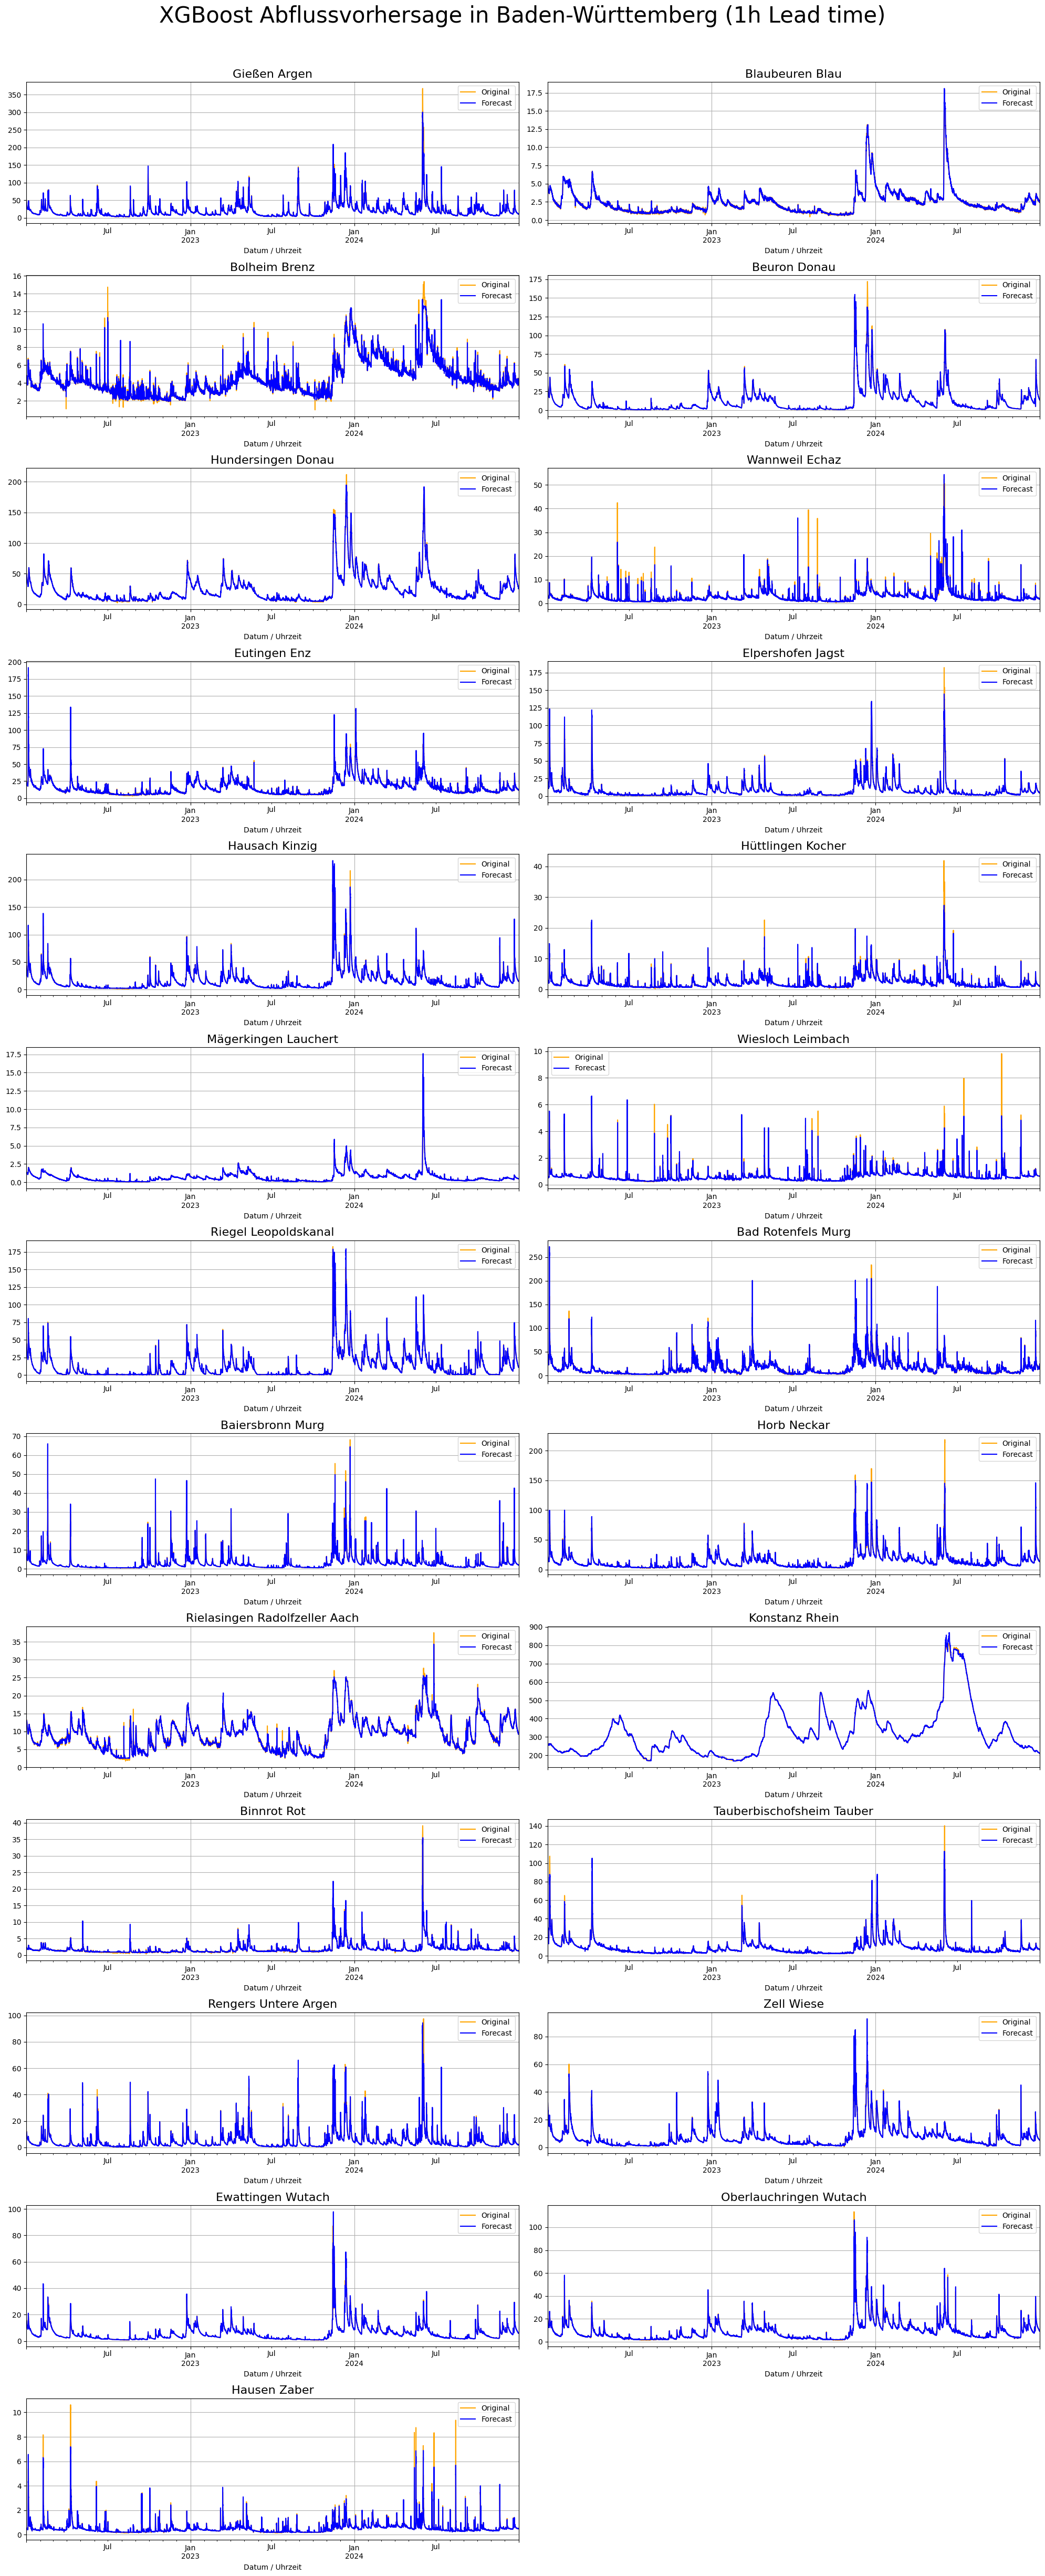

In [3]:
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import glob

# plot every forecast and actual data per station test set in one figure and store the figure as png file,
def plot_every_forecast_1h():
    hourly = pd.read_csv("Evaluation/XGBoost_Metriken_stündlich_1h.csv", parse_dates=["Datum / Uhrzeit"])

    stations = hourly["Stationsname"].unique()

    plotted = []
    fig, axes = plt.subplots(13,2, figsize=(20, 50))
    axes = axes.ravel()
    for i,s in enumerate(stations):

        df_station = hourly[hourly["Stationsname"] == s].copy()
        df_station = df_station.sort_values("Datum / Uhrzeit")
        df_station = df_station.set_index("Datum / Uhrzeit")

        df_station["Abfluss in m^3/s"].plot(ax=axes[i], label="Original", color="orange")
        df_station["Forecast"].plot(ax=axes[i], label="Forecast", color="blue")
        axes[i].set_title(f"{s}", fontsize=16)
        axes[i].grid(True)
        axes[i].legend()
    for j in range(len(stations), 26):
        axes[j].set_visible(False)

    fig.suptitle("XGBoost Abflussvorhersage in Baden-Württemberg (1h Lead time)", fontsize=30)
    fig.tight_layout(rect=[0, 0, 1, 0.97])
    
    fig.savefig("Plot/Forecasts/XGBoost_Alle_Forecasts_1h.png", dpi=300, bbox_inches="tight")
    plt.show()

plot_every_forecast_1h()

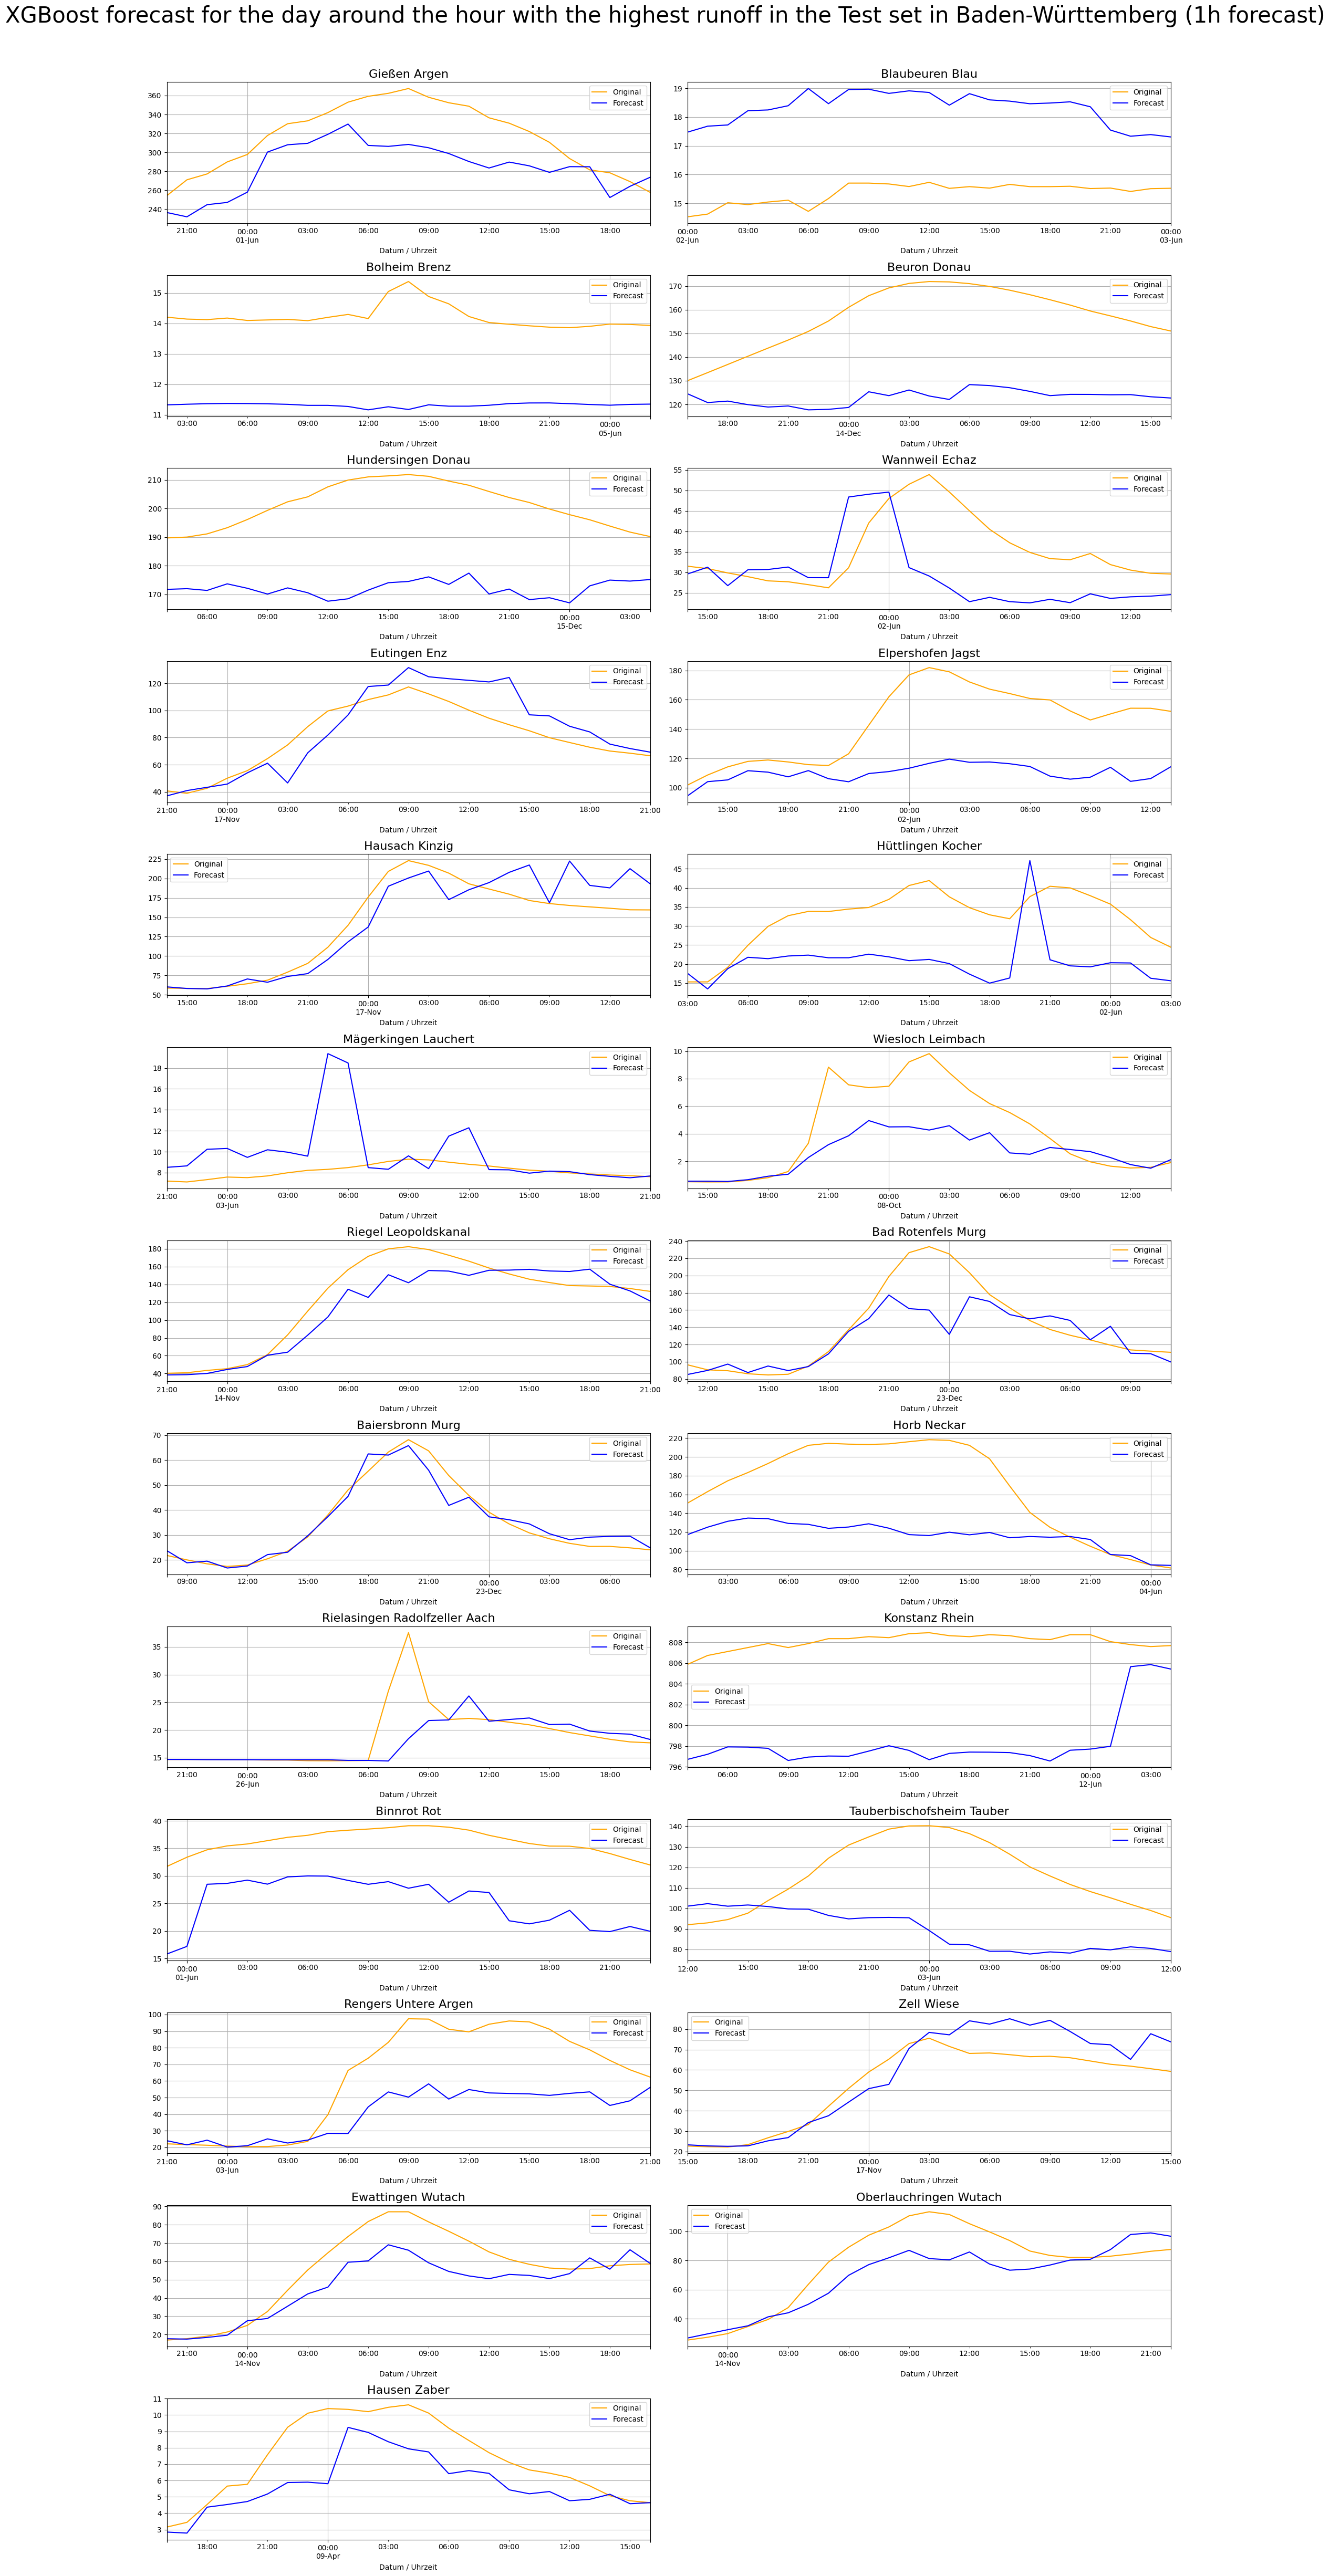

In [24]:
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import glob

# plot forecast and actual data for the day around the hour with the highest surface runoff in the test set for every station.
def plot_extrem_day_forecast():
    hourly_1h = pd.read_csv("Evaluation/XGBoostMetriken_stündlich_1h.csv", parse_dates=["Datum / Uhrzeit"])
    hourly_6h = pd.read_csv("Evaluation/XGBoost_Metriken_stündlich_6h.csv", parse_dates=["Datum / Uhrzeit"])
    hourly_24h = pd.read_csv("Evaluation/XGBoost_Metriken_stündlich_24h.csv", parse_dates=["Datum / Uhrzeit"])
    hourly_72h = pd.read_csv("Evaluation/XGBoost_Metriken_stündlich_72h.csv", parse_dates=["Datum / Uhrzeit"])

    stations = hourly["Stationsname"].unique()

    plotted = []
    fig, axes = plt.subplots(13,2, figsize=(20, 50))
    axes = axes.ravel()
    for i,s in enumerate(stations):

        df_station = hourly[hourly["Stationsname"] == s].copy()
        df_station = df_station.sort_values("Datum / Uhrzeit")
        df_station = df_station.set_index("Datum / Uhrzeit")

        max_hour = df_station["Abfluss in m^3/s"].idxmax()

        start = max_hour - pd.Timedelta(hours=12)
        end = max_hour + pd.Timedelta(hours=12)
        max_day = df_station.loc[start:end]

        max_day["Abfluss in m^3/s"].plot(ax=axes[i], label="Original", color="orange")
        max_day["Forecast"].plot(ax=axes[i], label="Forecast", color="blue")
        axes[i].set_title(f"{s}", fontsize=16)
        axes[i].grid(True)
        axes[i].legend()
    for j in range(len(stations), 26):
        axes[j].set_visible(False)

    fig.suptitle("XGBoost forecast for the day around the hour with the highest runoff in the Test set in Baden-Württemberg (1h forecast)", fontsize=30)
    fig.tight_layout(rect=[0, 0, 1, 0.97])

    fig.savefig("Plot/Forecasts/Alle_Forecasts_Maximaler_Tag_H1.png", dpi=300, bbox_inches="tight")
    plt.show()

plot_extrem_day_forecast()

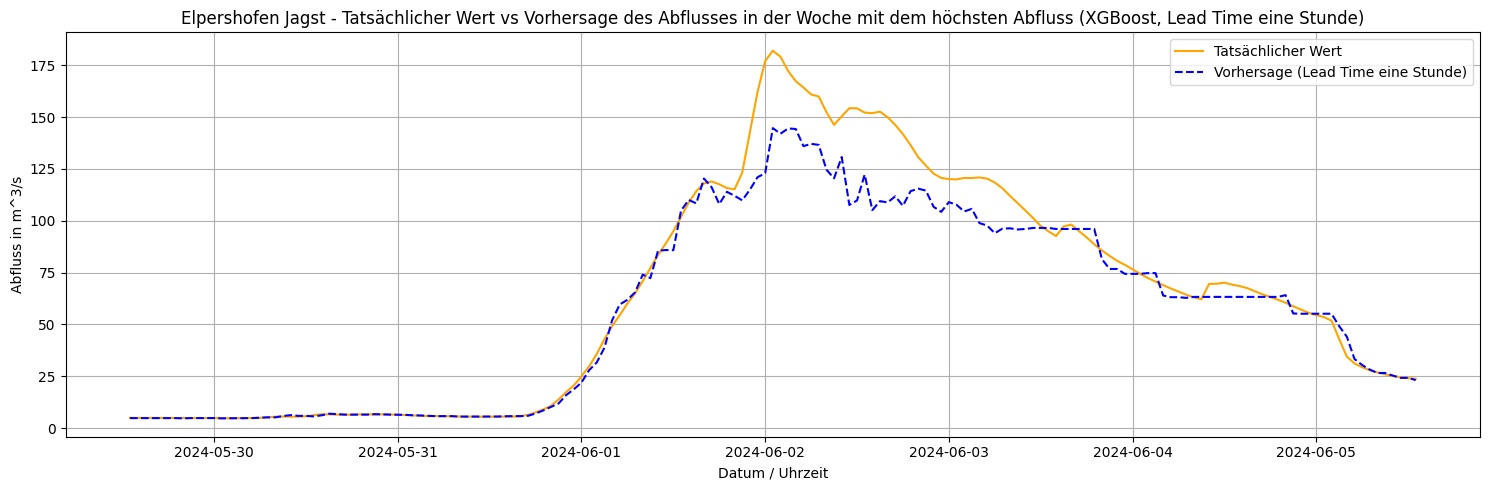

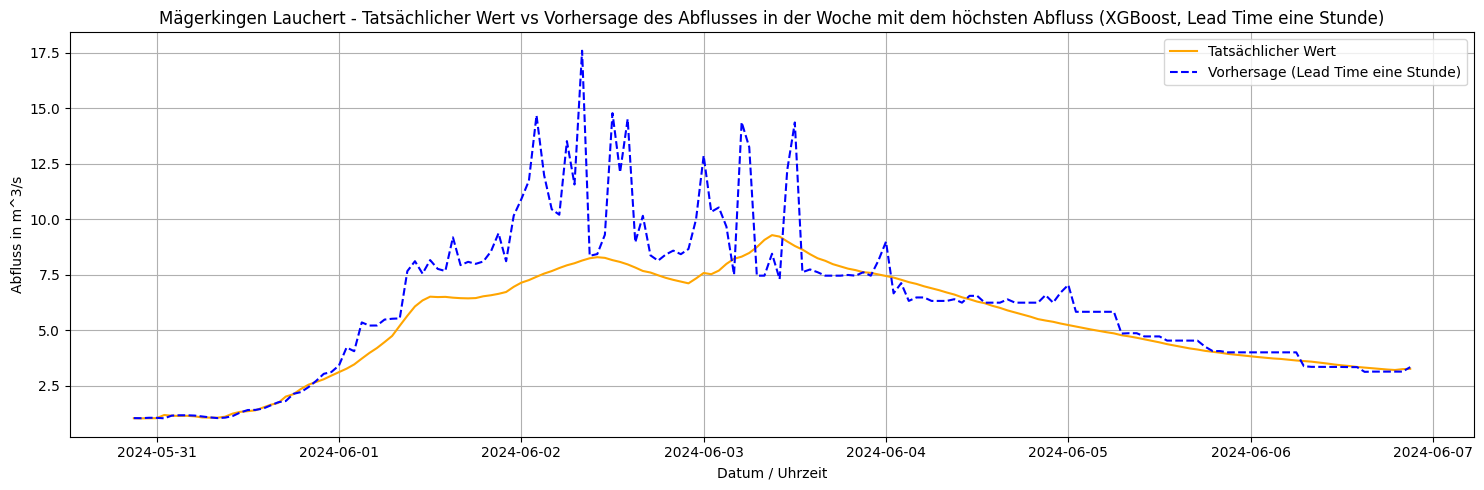

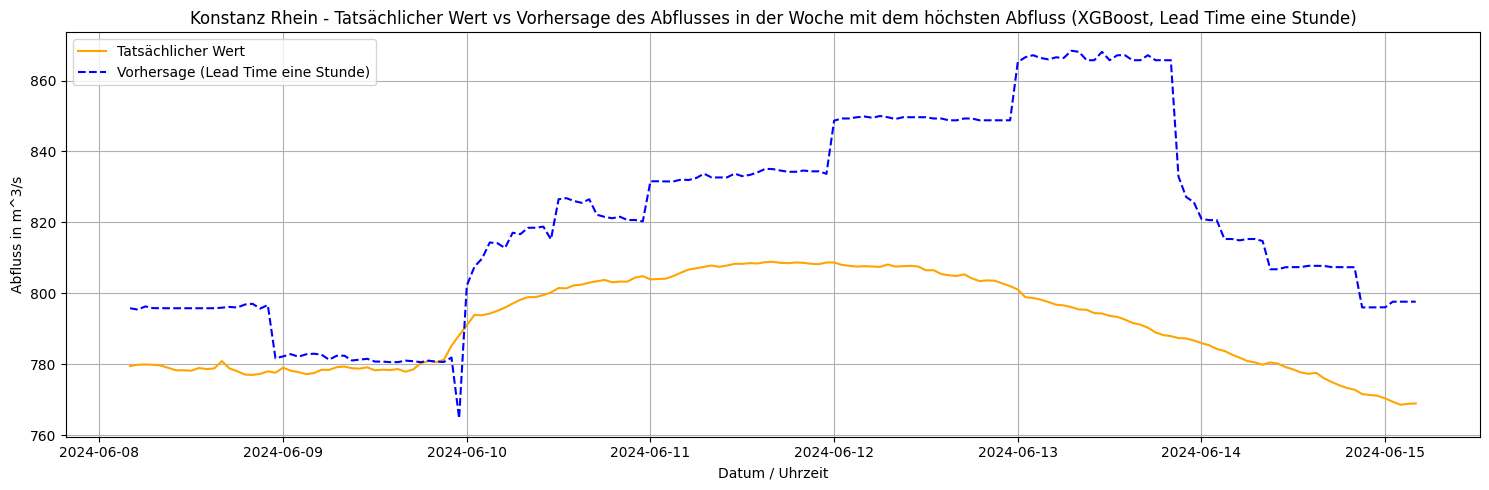

In [1]:
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import glob

# plot forecast and actual data for the week around the hour with the highest surface runoff in the test set for the three example stations.
def plot_extrem_week_examples():
    hourly = pd.read_csv("Evaluation/XGBoost_Metriken_stündlich_1h.csv", parse_dates=["Datum / Uhrzeit"])

    
    selected_stations = ["Elpershofen Jagst", "Mägerkingen Lauchert", "Konstanz Rhein"]
        
    for station in selected_stations:
        df_station = hourly[hourly["Stationsname"] == station].copy()
        df_station = df_station.sort_values("Datum / Uhrzeit")
        df_station = df_station.set_index("Datum / Uhrzeit")

        max_hour = df_station["Abfluss in m^3/s"].idxmax()

        start = max_hour - pd.Timedelta(hours=84)
        end = max_hour + pd.Timedelta(hours=84)
        max_week = df_station.loc[start:end]
        
        plt.figure(figsize=(15,5))
        plt.plot(max_week.index, max_week["Abfluss in m^3/s"], label="Tatsächlicher Wert", color="orange")
        plt.plot(max_week.index, max_week["Forecast"], label="Vorhersage (Lead Time eine Stunde)", linestyle="--", color="blue")
        plt.title(f"{station} - Tatsächlicher Wert vs Vorhersage des Abflusses in der Woche mit dem höchsten Abfluss (XGBoost, Lead Time eine Stunde)")
        plt.xlabel("Datum / Uhrzeit")
        plt.ylabel("Abfluss in m^3/s")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.savefig(f"Plot/Forecasts/{station}_Forecasts_extrem_week_H1.png", dpi=300, bbox_inches="tight")
        plt.show()

plot_extrem_week_examples()
        
        
            